# Лабораторная работа 5
## Сети с обратными связями
Вариант 3 

Сутдент: Будникова Валерия Павловна 

группа: М8О-407Б-19  

### Цель работы: 
исследование свойств сетей Хопфилда, Хэмминга и Элмана, алгорит- мов обучения, а также применение сетей в задачах распознавания статических и динамических образов.


### Задание:
1. Использовать сеть Элмана для распознавания динамических образов. Проверить качество распознавания.
2. Использовать сеть Хопфилда для распознавания статических образов. Проверить качество распознавания.

In [1]:
import math
import torch as tr
import torch.nn as nn
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import time

### Реализация:

In [2]:

k1 = np.arange(0, 1, 0.025)
p1 = np.sin(4 * math.pi * k1)
t1 = -1 * np.ones(len(p1))


k2 = np.arange(0.9, 3.1, 0.025)
p2 = np.sin(k2*k2 - 15 * k2 + 3) - np.sin(k2) * np.sin(k2) + 0.5
t2 = 1 * np.ones(len(p2))

R = [3, 5, 2]

Функции, для получения сигнала:

In [3]:
def make_signal(p1, p2, t1, t2, R):
    r1, r2, r3 = R[0], R[1], R[2]
    signal = np.concatenate((np.tile(p1, r1), p2, np.tile(p1, r2), p2, np.tile(p1, r3), p2))
    labels = np.concatenate((np.tile(t1, r1), t2, np.tile(t1, r2), t2, np.tile(t1, r3), t2))
    return signal, labels

def split_for_train(sign, lab, w):
    split_sign = [np.array(sign[i:i+w], dtype=np.float32) for i in range(0, len(sign) - w)]
    split_lab = [np.array(lab[i:i+w], dtype=np.float32) for i in range(0, len(lab) - w)]
    return [(x, y) for x, y in zip(split_sign, split_lab)]

Реализация алгоритма Элмана:

In [4]:
class ElmanLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super(ElmanLayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.W1 = nn.Parameter(tr.randn(in_features, out_features))
        self.W2 = nn.Parameter(tr.randn(out_features, out_features))
        self.b = nn.Parameter(tr.randn(out_features))
        self.prew = tr.zeros(in_features).clone().detach()

    
    def clear_memory(self):
        self.prew = tr.zeros(self.in_features).clone().detach()
    
    def forward(self, input):
        prew_par = tr.matmul(self.prew, self.W2)
        out = tr.matmul(input, self.W1)
        out = tr.add(out, prew_par)
        out = tr.add(out, self.b)
        out = tr.tanh(out)
        self.prew = out.clone().detach()
        return out




Создание модели

In [5]:
win = 8

elman = ElmanLayer(win, 8)
linear = nn.Linear(8, win)

model = nn.Sequential(elman, linear)
optim = tr.optim.Adam(model.parameters(), lr = 1e-3)

s, l = make_signal(p1, p2, t1, t2, R)

data_train = split_for_train(s, l, win) 
train_loader = tr.utils.data.DataLoader(data_train, batch_size = 1, shuffle = False)

print(model)

Sequential(
  (0): ElmanLayer()
  (1): Linear(in_features=8, out_features=8, bias=True)
)


Обучение сети:

In [9]:
epochs = 80
train_loss = []

model.train()

start_time = time.time()
for i in range(epochs):
    
    elman.clear_memory()
    last_loss = []

    for data, labels in train_loader:

        output_pred = model(data)

        f_loss = nn.MSELoss()
        loss = tr.sqrt(f_loss(output_pred, labels))
        last_loss += [loss.item()]

        optim.zero_grad()
        loss.backward()
        optim.step()
    
    train_loss += [np.mean(last_loss)]
end_time = time.time()

print("epochs: ", epochs)
print("time = ", end_time - start_time)

epochs:  80
time =  76.16901993751526


In [10]:
model.eval()
elman.clear_memory()

predict = []
for x, y in data_train:
    predict += [model(tr.tensor(x)).detach().numpy().item(0)]

predict = np.array(predict)

predict[predict > 0] = 1
predict[predict < 0] = -1

График функции ошибки и результаты:

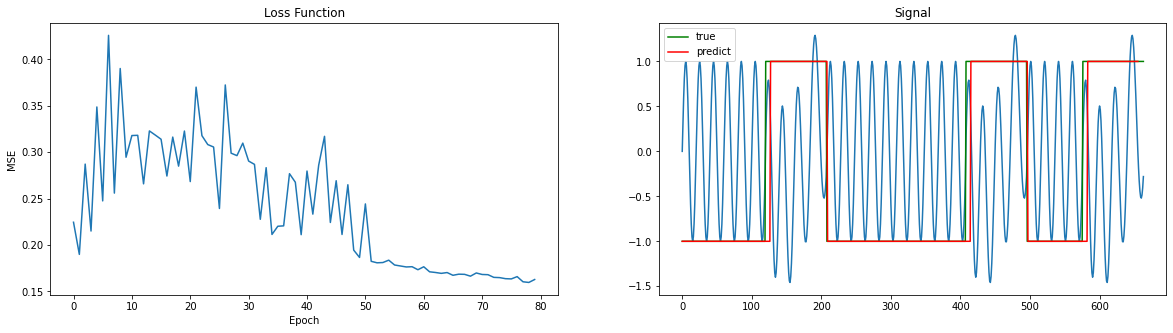

In [11]:
fig, axes = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(20)

axes[0].set_title("Loss Function")
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('MSE')
axes[0].plot(train_loss)

axes[1].set_title("Signal")
axes[1].plot(s)
axes[1].plot(l, color = 'green', label = 'true')
axes[1].plot(predict, color = 'red', label = 'predict')
plt.legend()




# 2

Реализация слоя Хопфилда:

In [9]:
class HopfieldLayer(nn.Module):
    def __init__(self, in_features):
        super(HopfieldLayer, self).__init__()
        self.in_features = in_features
        self.W = nn.Parameter(tr.zeros(in_features, in_features))
        self.b = nn.Parameter(tr.zeros(in_features))
        self.prew = tr.FloatTensor(tr.zeros(in_features))

    def set_init_value(self, value):
        self.prew = tr.FloatTensor(value)
    
    def forward(self, input = 0):
        out = tr.matmul(self.prew, self.W)
        out = tr.add(out, self.b)
        out = tr.clamp(out, min = -1, max = 1)
        self.prew = tr.FloatTensor(out)
        return out

Функция для загрузки изображений:

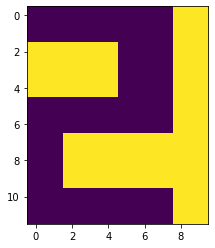

In [10]:
import PIL
from PIL import Image

def load_image(path, width=320, height=240):
    image = Image.open(path)
    image = image.convert('RGB')  # удалить альфа канал, иногда он может присутствовать!
    image = image.resize((width, height), Image.ANTIALIAS)
    image = np.asarray(image, dtype=np.float32)
    image = np.dot(image[..., :3], [0.2989, 0.5870, 0.1140]).astype(np.float32)  # получить float32 вместо double
    image = (image - 127.5) / 127.5  # нормализовать [-1..1]
    # np.reshape(image, width * height)
    return image, image.flatten()


im2, im2_fl = load_image('/Users/valeriabudnikova/УНИК/7S/NeuroInf/l5/2.png', 10, 12)
im4, im4_fl = load_image('/Users/valeriabudnikova/УНИК/7S/NeuroInf/l5/4.png', 10, 12)
im3, im3_fl = load_image('/Users/valeriabudnikova/УНИК/7S/NeuroInf/l5/3.png', 10, 12)

plt.imshow(im2)
plt.show()


Создание и тренировка сети. Также вывод графика функции ошибки:

epochs:  20
time =  0.29798388481140137


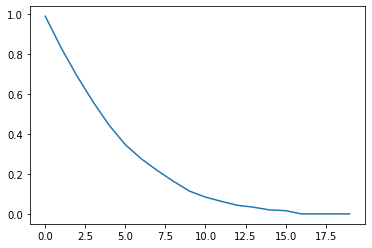

In [11]:
w, h = 10, 12

model2 = HopfieldLayer(w * h)
optim2 = tr.optim.Adam(model2.parameters(), 1e-3)
data_train2 = [(im2_fl, im2_fl), (im3_fl, im3_fl), (im4_fl, im4_fl)]
noise = np.random.normal(0, 0.5, im2_fl.shape)
data_noise = [np.copy(x[0])  + noise for x in data_train2]
train_loader2 = tr.utils.data.DataLoader(data_train2, batch_size = 1, shuffle = True)


epochs = 20
train_loss = []

model2.train()

start_time = time.time()
for i in range(epochs):

    last_loss = []

    for input, outputt in train_loader2:

        model2.set_init_value(input)
        output = model2()

        f_loss = nn.MSELoss()
        loss = tr.sqrt(f_loss(output, tr.FloatTensor(outputt)))
        last_loss += [loss.item()]
    
        optim2.zero_grad()
        loss.backward()
        optim2.step()
    train_loss += [np.mean(last_loss)]
    
end_time = time.time()

print("epochs: ", epochs)
print("time = ", end_time - start_time)

plt.plot(np.arange(0, len(train_loss)), train_loss );

Распознавание проходит на зашубленных данных:

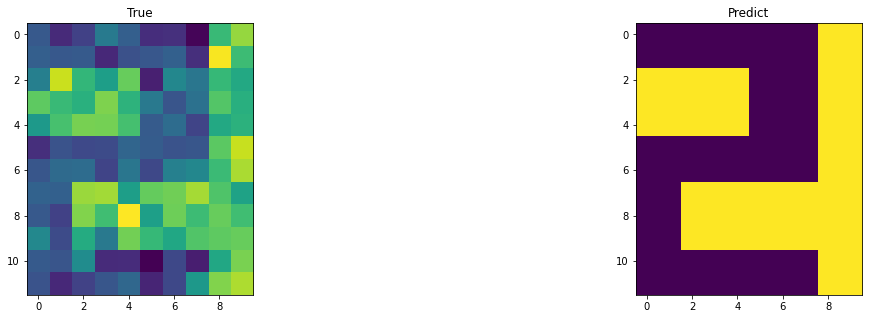

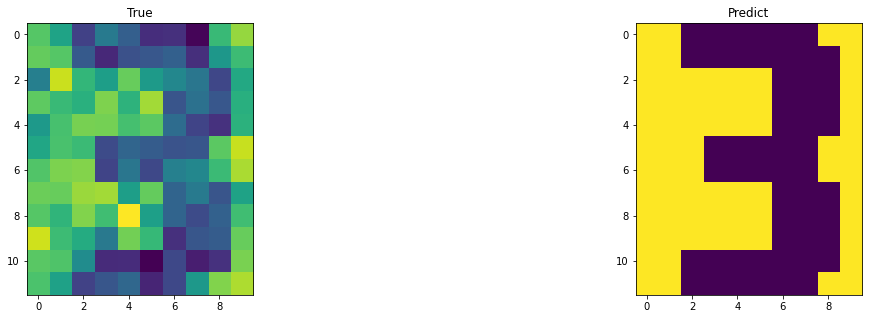

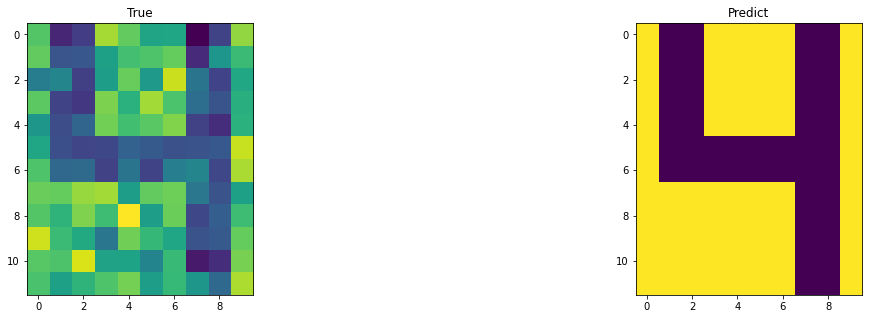

In [12]:
model2.eval()
for i in data_noise:

    frames = []

    im = i

    im_init = np.copy(im)


    model2.set_init_value(im_init)

    for i in range(150):
        output = model2()
        output = output.detach().numpy()
        output = (output + 1)/2
        output = output.reshape((h, w))
        frames += [output]

    out_true = im.reshape((h, w))

    fig, axes = plt.subplots(1, 2)
    fig.set_figheight(5)
    fig.set_figwidth(20)

    axes[0].set_title("True")
    axes[0].imshow(out_true)

    axes[1].set_title("Predict")
    axes[1].imshow(frames[-1])


#### Вывод
В данной лабораторной работе я создала две сети - сеть Элмана и сеть Хопфилда. Сети были проверены на распознавании сигнала и распозновании картинок. Также был приведен график функции ошибки для сети Элмана.